# Chapter 14. Adventures in Covariance

In [1]:
import math
import os

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel
from IPython.display import Image, set_matplotlib_formats
from matplotlib.patches import Ellipse, transforms

import jax.numpy as jnp
from jax import ops, random, vmap
from jax.scipy.special import expit

import numpy as onp
import numpyro as numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import effective_sample_size, print_summary
from numpyro.infer import MCMC, NUTS, Predictive

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_host_device_count(4)

### Code 14.1

In [2]:
a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

### Code 14.2

In [3]:
Mu = jnp.array([a, b])

### Code 14.3

In [4]:
cov_ab = sigma_a * sigma_b * rho
Sigma = jnp.array([[sigma_a ** 2, cov_ab], [cov_ab, sigma_b ** 2]])

### Code 14.4

In [5]:
jnp.array([1, 2, 3, 4]).reshape(2, 2).T

Array([[1, 3],
       [2, 4]], dtype=int32)

### Code 14.5

In [6]:
sigmas = jnp.array([sigma_a, sigma_b])  # standard deviations
Rho = jnp.array([[1, rho], [rho, 1]])  # correlation matrix

# now matrix multiply to get covariance matrix
Sigma = jnp.diag(sigmas) @ Rho @ jnp.diag(sigmas)

### Code 14.6

In [7]:
N_cafes = 20

### Code 14.7

In [8]:
seed = random.PRNGKey(5)  # used to replicate example
vary_effects = dist.MultivariateNormal(Mu, Sigma).sample(seed, (N_cafes,))

### Code 14.8

In [9]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

### Code 14.9

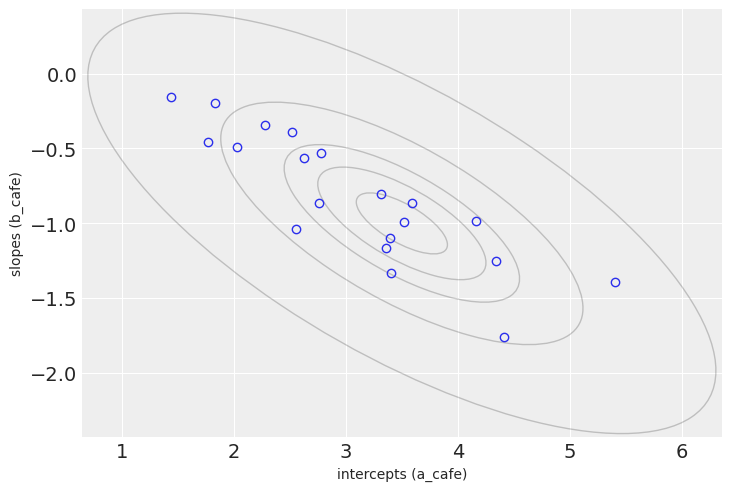

In [11]:
plt.plot(a_cafe, b_cafe, "o", mfc="none")
plt.gca().set(xlabel="intercepts (a_cafe)", ylabel="slopes (b_cafe)")

# overlay population distribution
# Ref: https://matplotlib.org/gallery/statistics/confidence_ellipse.html
for l in [0.1, 0.3, 0.5, 0.8, 0.99]:
    pearson = Sigma[0, 1] / jnp.sqrt(Sigma[0, 0] * Sigma[1, 1])
    ellipse = Ellipse(
        (0, 0),
        jnp.sqrt(1 + pearson),
        jnp.sqrt(1 - pearson),
        edgecolor="k",
        alpha=0.2,
        facecolor="none",
    )
    std_dev = dist.Normal().icdf((1 + jnp.sqrt(l)) / 2)
    scale_x = 2 * std_dev * jnp.sqrt(Sigma[0, 0])
    scale_y = 2 * std_dev * jnp.sqrt(Sigma[1, 1])
    scale = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y)
    ellipse.set_transform(scale.translate(Mu[0], Mu[1]) + plt.gca().transData)
    plt.gca().add_patch(ellipse)

### Code 14.10

In [12]:
seed = random.PRNGKey(22)
N_visits = 10
afternoon = jnp.tile(jnp.arange(2), N_visits * N_cafes // 2)
cafe_id = jnp.repeat(jnp.arange(N_cafes), N_visits)
mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes
wait = dist.Normal(mu, sigma).sample(seed)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

d

,cafe,afternoon,wait
0,0,0,1.152118
1,0,1,1.344605
2,0,0,2.065645
3,0,1,0.164731
4,0,0,1.053376
...,...,...,...
195,19,1,2.343245
196,19,0,2.114601
197,19,1,2.254453
198,19,0,0.814379


### Code 14.11

(array([  596.,  3856.,  9633., 15832., 19975., 20020., 15967.,  9736.,
         3772.,   613.]),
 array([-9.44011986e-01, -7.55322397e-01, -5.66632807e-01, -3.77943188e-01,
        -1.89253584e-01, -5.63979149e-04,  1.88125625e-01,  3.76815230e-01,
         5.65504849e-01,  7.54194438e-01,  9.42884028e-01]),
 <BarContainer object of 10 artists>)

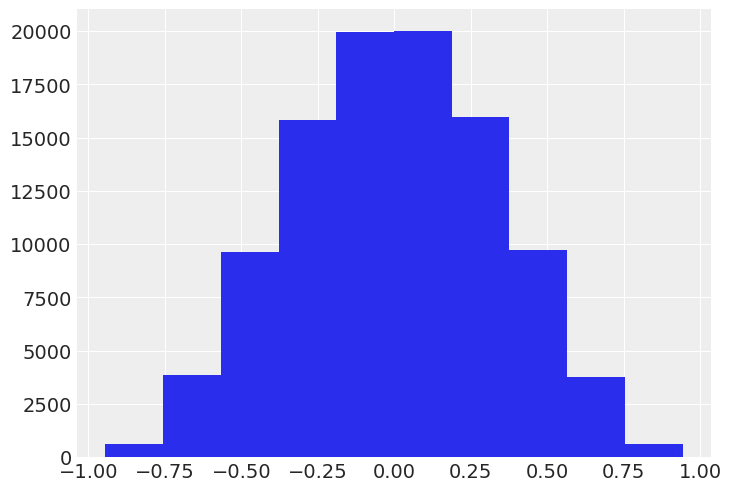

In [26]:
plt.hist(R[:, 0, 1])

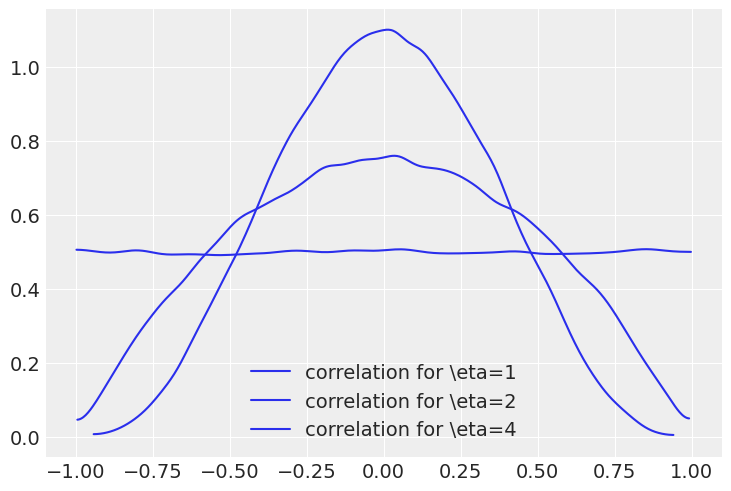

In [35]:
_, ax = plt.subplots()
for conc in (1, 2, 4):
    R = dist.LKJ(dimension=2, concentration=conc).sample(random.PRNGKey(10), (int(1e5),))
    az.plot_kde(R[:, 0, 1], label=f"correlation for concentration={conc}", ax=ax, fill_kwargs={"color": "k"})
plt.show()

### Code 14.12

In [37]:
def model(cafe, afternoon, wait):
    a = numpyro.sample("a", dist.Normal(5, 2))
    b = numpyro.sample("b", dist.Normal(-1, 0.5))
    sigma_cafe = numpyro.sample("sigma_cafe", dist.Exponential(1).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    Rho = numpyro.sample("Rho", dist.LKJ(2, 2))
    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
    a_cafe_b_cafe = numpyro.sample(
        "a_cafe,b_cafe", dist.MultivariateNormal(jnp.stack([a, b]), cov).expand([20])
    )
    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    numpyro.sample("wait", dist.Normal(mu, sigma), obs=wait)


m14_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m14_1.run(random.PRNGKey(0), d.cafe.values, d.afternoon.values, d.wait.values)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

### Code 14.13

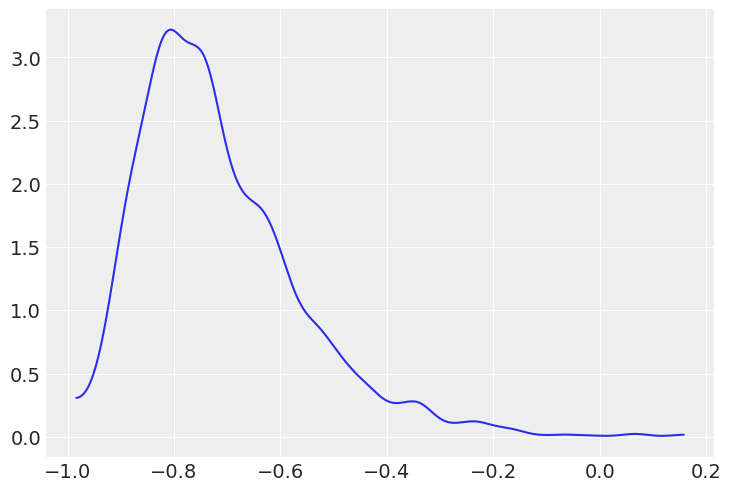

In [39]:
post = m14_1.get_samples()
az.plot_kde(post["Rho"][:, 0, 1])
plt.show()

### Code 14.14

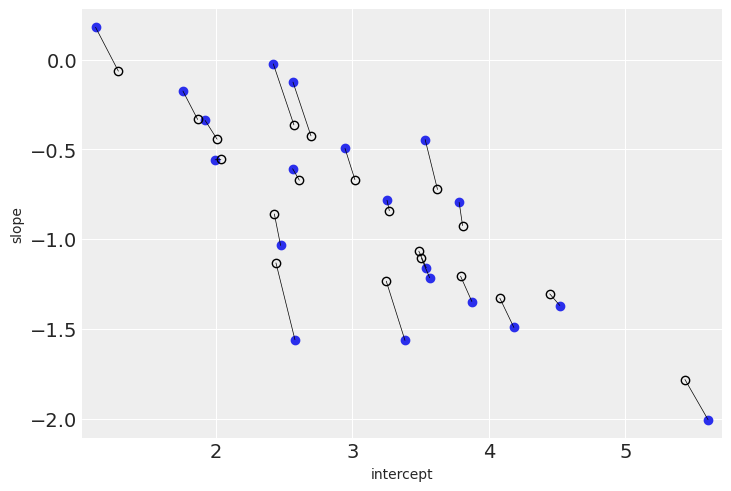

In [40]:
# compute unpooled estimates directly from data
a1 = jnp.array(
    [jnp.mean(wait[(cafe_id == i) & (afternoon == 0)]) for i in range(N_cafes)]
)
b1 = (
    jnp.array(
        [jnp.mean(wait[(cafe_id == i) & (afternoon == 1)]) for i in range(N_cafes)]
    )
    - a1
)

# extract posterior means of partially pooled estimates
post = m14_1.get_samples()
a2 = jnp.mean(post["a_cafe,b_cafe"][..., 0], 0)
b2 = jnp.mean(post["a_cafe,b_cafe"][..., 1], 0)

# plot both and connect with lines
plt.plot(a1, b1, "o")
plt.gca().set(
    xlabel="intercept",
    ylabel="slope",
    ylim=(jnp.min(b1) - 0.1, jnp.max(b1) + 0.1),
    xlim=(jnp.min(a1) - 0.1, jnp.max(a1) + 0.1),
)
plt.plot(a2, b2, "ko", mfc="none")
for i in range(N_cafes):
    plt.plot([a1[i], a2[i]], [b1[i], b2[i]], "k", lw=0.5)
fig, ax = plt.gcf(), plt.gca()

### Code 14.15

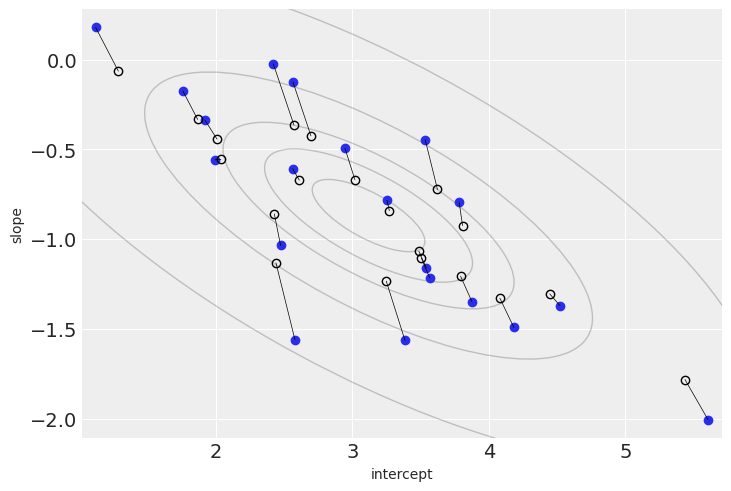

In [41]:
# compute posterior mean bivariate Gaussian
Mu_est = jnp.array([jnp.mean(post["a"]), jnp.mean(post["b"])])
rho_est = jnp.mean(post["Rho"][:, 0, 1])
sa_est = jnp.mean(post["sigma_cafe"][:, 0])
sb_est = jnp.mean(post["sigma_cafe"][:, 1])
cov_ab = sa_est * sb_est * rho_est
Sigma_est = jnp.array([[sa_est ** 2, cov_ab], [cov_ab, sb_est ** 2]])

# draw contours
for l in [0.1, 0.3, 0.5, 0.8, 0.99]:
    pearson = Sigma_est[0, 1] / jnp.sqrt(Sigma_est[0, 0] * Sigma_est[1, 1])
    ellipse = Ellipse(
        (0, 0),
        jnp.sqrt(1 + pearson),
        jnp.sqrt(1 - pearson),
        edgecolor="k",
        alpha=0.2,
        facecolor="none",
    )
    std_dev = dist.Normal().icdf((1 + jnp.sqrt(l)) / 2)
    scale_x = 2 * std_dev * jnp.sqrt(Sigma_est[0, 0])
    scale_y = 2 * std_dev * jnp.sqrt(Sigma_est[1, 1])
    scale = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y)
    ellipse.set_transform(scale.translate(Mu_est[0], Mu_est[1]) + ax.transData)
    ax.add_patch(ellipse)
fig

### Code 14.16

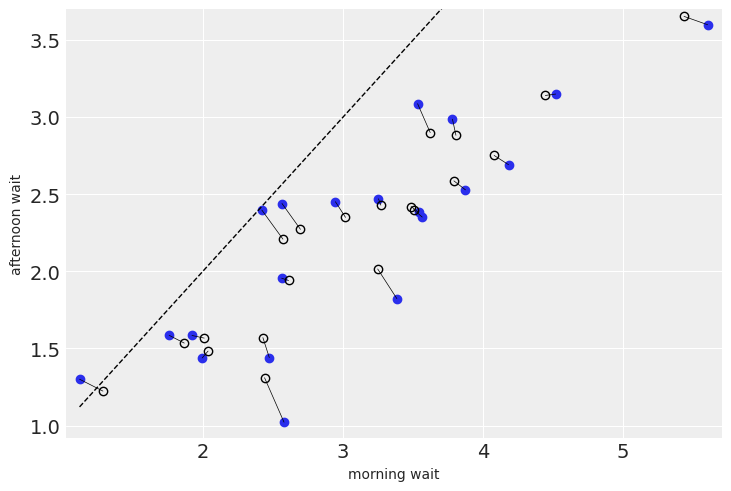

In [42]:
# convert varying effects to waiting times
wait_morning_1 = a1
wait_afternoon_1 = a1 + b1
wait_morning_2 = a2
wait_afternoon_2 = a2 + b2

# plot both and connect with lines
plt.plot(wait_morning_1, wait_afternoon_1, "o")
plt.gca().set(
    xlabel="morning wait",
    ylabel="afternoon wait",
    ylim=(jnp.min(wait_afternoon_1) - 0.1, jnp.max(wait_afternoon_1) + 0.1),
    xlim=(jnp.min(wait_morning_1) - 0.1, jnp.max(wait_morning_1) + 0.1),
)
plt.plot(wait_morning_2, wait_afternoon_2, "ko", mfc="none")
for i in range(N_cafes):
    plt.plot(
        [wait_morning_1[i], wait_morning_2[i]],
        [wait_afternoon_1[i], wait_afternoon_2[i]],
        "k",
        lw=0.5,
    )
x = jnp.linspace(jnp.min(wait_morning_1), jnp.max(wait_morning_1), 101)
plt.plot(x, x, "k--", lw=1)
fig, ax = plt.gcf(), plt.gca()

### Code 14.17

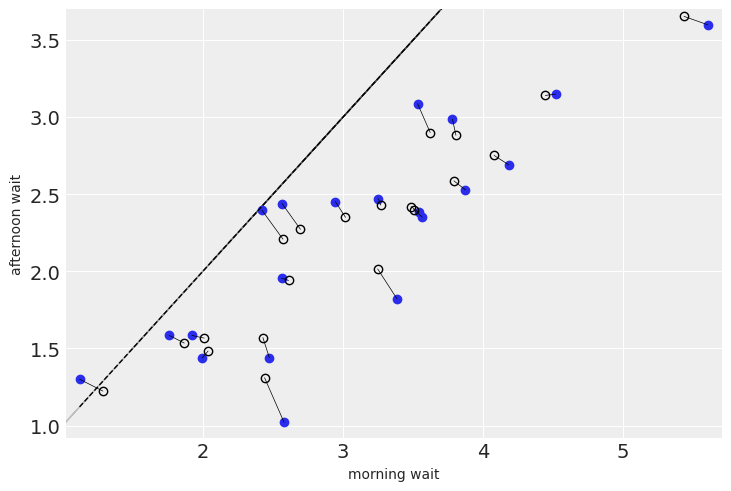

In [45]:
# now shrinkage distribution by simulation
v = dist.MultivariateNormal(Mu_est, Sigma_est).sample(random.PRNGKey(0), (10000,))
# v = ops.index_add(v, ops.index[:, 1], v[:, 0])  # calculate afternoon wait
v = v.at[:, 1].set(v[:, 0])
Sigma_est2 = jnp.cov(v, rowvar=False)
Mu_est2 = Mu_est
# Mu_est2 = ops.index_add(Mu_est2, ops.index[1], Mu_est2[0])
Mu_est2 = Mu_est2.at[1].set(Mu_est2[0])

# draw contours
for l in [0.1, 0.3, 0.5, 0.8, 0.99]:
    pearson = Sigma_est2[0, 1] / jnp.sqrt(Sigma_est2[0, 0] * Sigma_est2[1, 1])
    ellipse = Ellipse(
        (0, 0),
        jnp.sqrt(1 + pearson),
        jnp.sqrt(1 - pearson),
        edgecolor="k",
        alpha=0.2,
        facecolor="none",
    )
    std_dev = dist.Normal().icdf((1 + jnp.sqrt(l)) / 2)
    scale_x = 2 * std_dev * jnp.sqrt(Sigma_est2[0, 0])
    scale_y = 2 * std_dev * jnp.sqrt(Sigma_est2[1, 1])
    scale = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y)
    ellipse.set_transform(scale.translate(Mu_est2[0], Mu_est2[1]) + ax.transData)
    ax.add_patch(ellipse)
fig

### Code 14.18

In [46]:
chimpanzees = pd.read_csv("../data/chimpanzees.csv", sep=";")
d = chimpanzees
d["block_id"] = d.block
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition

dat = dict(
    L=d.pulled_left.values,
    tid=d.treatment.values - 1,
    actor=d.actor.values - 1,
    block_id=d.block_id.values - 1,
)


def model(tid, actor, block_id, L):
    # fixed priors
    g = numpyro.sample("g", dist.Normal(0, 1).expand([4]))
    sigma_actor = numpyro.sample("sigma_actor", dist.Exponential(1).expand([4]))
    Rho_actor = numpyro.sample("Rho_actor", dist.LKJ(4, 4))
    sigma_block = numpyro.sample("sigma_block", dist.Exponential(1).expand([4]))
    Rho_block = numpyro.sample("Rho_block", dist.LKJ(4, 4))

    # adaptive priors
    cov_actor = jnp.outer(sigma_actor, sigma_actor) * Rho_actor
    alpha = numpyro.sample("alpha", dist.MultivariateNormal(0, cov_actor).expand([7]))
    cov_block = jnp.outer(sigma_block, sigma_block) * Rho_block
    beta = numpyro.sample("beta", dist.MultivariateNormal(0, cov_block).expand([6]))

    logit_p = g[tid] + alpha[actor, tid] + beta[block_id, tid]
    numpyro.sample("L", dist.Binomial(logits=logit_p), obs=L)


m14_2 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m14_2.run(random.PRNGKey(0), **dat)
print("Number of divergences: ", m14_2.get_extra_fields()["diverging"].sum())

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Number of divergences:  47


### Code 14.19

In [47]:
def model(tid, actor, block_id, L=None, link=False):
    # fixed priors
    g = numpyro.sample("g", dist.Normal(0, 1).expand([4]))
    sigma_actor = numpyro.sample("sigma_actor", dist.Exponential(1).expand([4]))
    L_Rho_actor = numpyro.sample("L_Rho_actor", dist.LKJCholesky(4, 2))
    sigma_block = numpyro.sample("sigma_block", dist.Exponential(1).expand([4]))
    L_Rho_block = numpyro.sample("L_Rho_block", dist.LKJCholesky(4, 2))

    # adaptive priors - non-centered
    z_actor = numpyro.sample("z_actor", dist.Normal(0, 1).expand([4, 7]))
    z_block = numpyro.sample("z_block", dist.Normal(0, 1).expand([4, 6]))
    alpha = numpyro.deterministic(
        "alpha", ((sigma_actor[..., None] * L_Rho_actor) @ z_actor).T
    )
    beta = numpyro.deterministic(
        "beta", ((sigma_block[..., None] * L_Rho_block) @ z_block).T
    )

    logit_p = g[tid] + alpha[actor, tid] + beta[block_id, tid]
    numpyro.sample("L", dist.Binomial(logits=logit_p), obs=L)

    # compute ordinary correlation matrixes from Cholesky factors
    if link:
        numpyro.deterministic("Rho_actor", L_Rho_actor @ L_Rho_actor.T)
        numpyro.deterministic("Rho_block", L_Rho_block @ L_Rho_block.T)
        numpyro.deterministic("p", expit(logit_p))


m14_3 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m14_3.run(random.PRNGKey(4387510), extra_fields=["diverging"], **dat)
print("Number of divergences: ", m14_3.get_extra_fields()["diverging"].sum())

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Number of divergences:  0


### Code 14.20

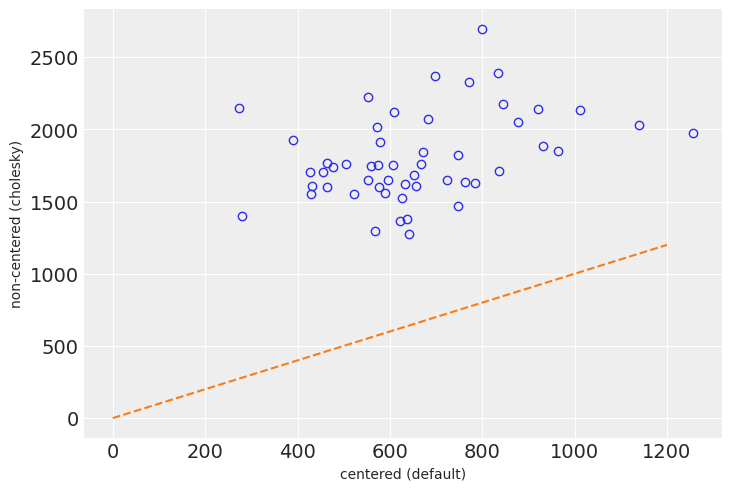

In [48]:
# extract n_eff values for each model
post_nc = m14_3.get_samples(group_by_chain=False)
post_nc = Predictive(m14_3.sampler.model, post_nc)(random.PRNGKey(1), link=True, **dat)
post_nc = {k: v.reshape((4, 500) + v.shape[1:]) for k, v in post_nc.items()}
neff_nc = jnp.concatenate(
    [effective_sample_size(post_nc[k].copy()).reshape(-1) for k in ["alpha", "beta"]]
)
post_c = m14_2.get_samples(group_by_chain=True)
neff_c = jnp.concatenate(
    [effective_sample_size(post_c[k].copy()).reshape(-1) for k in ["alpha", "beta"]]
)
plt.plot(neff_c, neff_nc, "o", mfc="none")
plt.gca().set(xlabel="centered (default)", ylabel="non-centered (cholesky)")
x = jnp.linspace(0, 1200, 100)
plt.plot(x, x, "--")
plt.show()

### Code 14.21

In [49]:
post = m14_3.get_samples(group_by_chain=True)
pars = {k: post[k] for k in ["sigma_actor", "sigma_block"]}
print_summary(pars, prob=0.89)


                    mean       std    median      5.5%     94.5%     n_eff     r_hat
sigma_actor[0]      1.36      0.46      1.28      0.68      2.02    830.59      1.01
sigma_actor[1]      0.91      0.38      0.85      0.32      1.41   1187.58      1.00
sigma_actor[2]      1.83      0.55      1.74      1.04      2.65   1568.34      1.00
sigma_actor[3]      1.58      0.59      1.44      0.73      2.42   1563.91      1.00
sigma_block[0]      0.42      0.33      0.35      0.00      0.83   1209.18      1.00
sigma_block[1]      0.44      0.35      0.36      0.00      0.86   1038.39      1.00
sigma_block[2]      0.29      0.26      0.22      0.00      0.61   1656.49      1.00
sigma_block[3]      0.47      0.37      0.39      0.00      0.93   1262.22      1.00



### Code 14.22

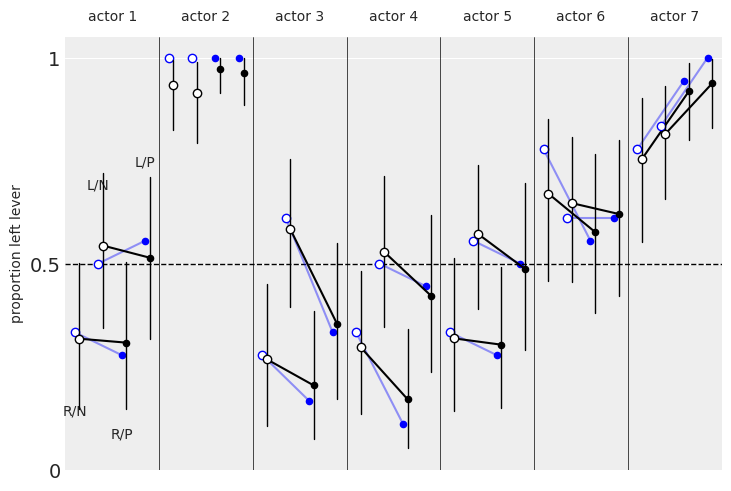

In [51]:
# compute mean for each actor in each treatment
pl = d.groupby(["actor", "treatment"])["pulled_left"].mean().unstack()

# generate posterior predictions using link
datp = dict(
    actor=jnp.repeat(jnp.arange(7), 4),
    tid=jnp.tile(jnp.arange(4), 7),
    block_id=jnp.repeat(4, 4 * 7),
)
p_post = Predictive(m14_3.sampler.model, m14_3.get_samples())(
    random.PRNGKey(1), **datp, link=True
)["p"]
p_mu = jnp.mean(p_post, 0)
p_ci = jnp.percentile(p_post, q=jnp.array((5.5, 94.5)), axis=0)

# set up plot
ax = plt.subplot(
    xlim=(0.5, 28.5),
    ylim=(0, 1.05),
    xlabel="",
    ylabel="proportion left lever",
    xticks=[],
)
plt.yticks(ticks=[0, 0.5, 1], labels=[0, 0.5, 1])
ax.axhline(0.5, c="k", lw=1, ls="--")
for j in range(1, 8):
    ax.axvline((j - 1) * 4 + 4.5, c="k", lw=0.5)
for j in range(1, 8):
    ax.annotate(
        "actor {}".format(j),
        ((j - 1) * 4 + 2.5, 1.1),
        ha="center",
        va="center",
        annotation_clip=False,
    )

xo = 0.1  # offset distance to stagger raw data and predictions
# raw data
for j in [1] + list(range(3, 8)):
    ax.plot((j - 1) * 4 + jnp.array([1, 3]) - xo, pl.loc[j, [1, 3]], "b", alpha=0.4)
    ax.plot((j - 1) * 4 + jnp.array([2, 4]) - xo, pl.loc[j, [2, 4]], "b", alpha=0.4)
x = jnp.arange(1, 29).reshape(7, 4) - xo
ax.scatter(
    x[:, [0, 1]].reshape(-1),
    pl.values[:, [0, 1]].reshape(-1),
    edgecolor="b",
    facecolor="w",
    zorder=3,
)
ax.scatter(
    x[:, [2, 3]].reshape(-1), pl.values[:, [2, 3]].reshape(-1), marker=".", c="b", s=80
)

yoff = 0.175
ax.annotate("R/N", (1 - xo, pl.values[0, 0] - yoff), ha="center", va="top")
ax.annotate("L/N", (2 - xo, pl.values[0, 1] + yoff), ha="center", va="bottom")
ax.annotate("R/P", (3 - xo, pl.values[0, 2] - yoff), ha="center", va="top")
ax.annotate("L/P", (4 - xo, pl.values[0, 3] + yoff), ha="center", va="bottom")

# posterior predictions
for j in [1] + list(range(3, 8)):
    ax.plot(
        (j - 1) * 4 + jnp.array([1, 3]) + xo, p_mu[(j - 1) * 4 + jnp.array([0, 2])], "k"
    )
    ax.plot(
        (j - 1) * 4 + jnp.array([2, 4]) + xo, p_mu[(j - 1) * 4 + jnp.array([1, 3])], "k"
    )
for i in range(1, 29):
    ax.plot(jnp.array([i, i]) + xo, p_ci[:, i - 1], "k", lw=1, zorder=4)
x = jnp.arange(1, 29).reshape(7, 4) + xo
ax.scatter(
    x[:, [0, 1]].reshape(-1),
    p_mu.reshape(7, 4)[:, [0, 1]].reshape(-1),
    edgecolor="k",
    facecolor="w",
    zorder=5,
)
ax.scatter(
    x[:, [2, 3]].reshape(-1),
    p_mu.reshape(7, 4)[:, [2, 3]].reshape(-1),
    marker=".",
    c="k",
    s=80,
    zorder=5,
)
plt.show()

### Code 14.23

In [52]:
with numpyro.handlers.seed(rng_seed=73):
    N = 500
    U_sim = numpyro.sample("U_sim", dist.Normal().expand([N]))
    Q_sim = numpyro.sample("Q_sim", dist.Categorical(logits=jnp.ones(4)).expand([N]))
    E_sim = numpyro.sample("E_sim", dist.Normal(U_sim + Q_sim))
    W_sim = numpyro.sample("W_sim", dist.Normal(U_sim + 0 * E_sim))
    dat_sim = dict(
        W=(W_sim - W_sim.mean()) / W_sim.std(),
        E=(E_sim - E_sim.mean()) / E_sim.std(),
        Q=(Q_sim - Q_sim.mean()) / Q_sim.std(),
    )

### Code 14.24

In [54]:
def model(E, W):
    aW = numpyro.sample("aW", dist.Normal(0, 0.2))
    bEW = numpyro.sample("bEW", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = aW + bEW * E
    numpyro.sample("W", dist.Normal(mu, sigma), obs=W)


m14_4 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m14_4.run(random.PRNGKey(0), dat_sim["E"], dat_sim["W"])
m14_4.print_summary(0.89)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        aW     -0.00      0.04     -0.00     -0.07      0.06   1868.56      1.00
       bEW      0.40      0.04      0.40      0.33      0.46   2122.41      1.00
     sigma      0.92      0.03      0.92      0.87      0.97   1591.50      1.00

Number of divergences: 0


### Code 14.25

In [55]:
def model(E, Q, W):
    aW = numpyro.sample("aW", dist.Normal(0, 0.2))
    bEW = numpyro.sample("bEW", dist.Normal(0, 0.5))
    bQW = numpyro.sample("bQW", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = aW + bEW * E + bQW * Q
    numpyro.sample("W", dist.Normal(mu, sigma), obs=W)


m14_5 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m14_5.run(random.PRNGKey(0), **dat_sim)
m14_5.print_summary(0.89)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        aW     -0.00      0.04     -0.00     -0.06      0.06   1818.15      1.00
       bEW      0.62      0.05      0.62      0.54      0.70   1765.91      1.00
       bQW     -0.37      0.05     -0.37     -0.46     -0.30   1849.01      1.00
     sigma      0.87      0.03      0.87      0.83      0.91   1828.99      1.00

Number of divergences: 0


### Code 14.26

In [57]:
def model(E, Q, W):
    aW = numpyro.sample("aW", dist.Normal(0, 0.2))
    aE = numpyro.sample("aE", dist.Normal(0, 0.2))
    bEW = numpyro.sample("bEW", dist.Normal(0, 0.5))
    bQE = numpyro.sample("bQE", dist.Normal(0, 0.5))
    Rho = numpyro.sample("Rho", dist.LKJ(2, 2))
    Sigma = numpyro.sample("Sigma", dist.Exponential(1).expand([2]))
    muW = aW + bEW * E
    muE = aE + bQE * Q
    cov = jnp.outer(Sigma, Sigma) * Rho
    numpyro.sample(
        "W,E",
        dist.MultivariateNormal(jnp.stack([muW, muE], -1), cov),
        obs=jnp.stack([W, E], -1),
    )


m14_6 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m14_6.run(random.PRNGKey(0), **dat_sim)
m14_6.print_summary(0.89)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
  Rho[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
  Rho[0,1]      0.48      0.05      0.48      0.39      0.56    875.83      1.00
  Rho[1,0]      0.48      0.05      0.48      0.39      0.56    875.83      1.00
  Rho[1,1]      1.00      0.00      1.00      1.00      1.00   1570.28      1.00
  Sigma[0]      0.99      0.04      0.99      0.93      1.06    927.75      1.00
  Sigma[1]      0.79      0.02      0.78      0.75      0.83   1494.38      1.00
        aE     -0.00      0.03     -0.00     -0.06      0.05   1835.70      1.00
        aW     -0.00      0.04     -0.00     -0.07      0.07   1928.23      1.00
       bEW      0.03      0.07      0.03     -0.09      0.13    840.12      1.00
       bQE      0.62      0.04      0.62      0.57      0.67   1417.42      1.00

Number of divergences: 0


### Code 14.27

In [28]:
m14_4x = MCMC(m14_4.sampler, num_warmup=500, num_samples=500, num_chains=4)
m14_4x.run(random.PRNGKey(1), dat_sim["E"], dat_sim["W"])
m14_6x = MCMC(m14_6.sampler, num_warmup=500, num_samples=500, num_chains=4)
m14_6x.run(random.PRNGKey(1), **dat_sim)

### Code 14.28

In [62]:
with numpyro.handlers.seed(rng_seed=73):
    N = 500
    U_sim = numpyro.sample("U_sim", dist.Normal().expand([N]))
    Q_sim = numpyro.sample("Q_sim", dist.Categorical(logits=jnp.ones(4)).expand([N]))
    E_sim = numpyro.sample("E_sim", dist.Normal(U_sim + Q_sim))
    W_sim = numpyro.sample("W_sim", dist.Normal(-U_sim + 0.2 * E_sim))
    dat_sim = dict(
        W=(W_sim - W_sim.mean()) / W_sim.std(),
        E=(E_sim - E_sim.mean()) / E_sim.std(),
        Q=(Q_sim - Q_sim.mean()) / Q_sim.std(),
    )

# m14_4x = MCMC(m14_4.sampler, num_warmup=500, num_samples=500, num_chains=4)
# m14_4x.run(random.PRNGKey(1), dat_sim["E"], dat_sim["W"])
m14_6x = MCMC(m14_6.sampler, num_warmup=500, num_samples=500, num_chains=4)
m14_6x.run(random.PRNGKey(1), **dat_sim)
m14_6x.print_summary(0.89)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
  Rho[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
  Rho[0,1]     -0.51      0.05     -0.51     -0.59     -0.42    808.97      1.00
  Rho[1,0]     -0.51      0.05     -0.51     -0.59     -0.42    808.97      1.00
  Rho[1,1]      1.00      0.00      1.00      1.00      1.00   1069.59      1.00
  Sigma[0]      1.08      0.05      1.08      1.01      1.16    870.37      1.00
  Sigma[1]      0.78      0.02      0.78      0.74      0.82   1739.82      1.00
        aE     -0.00      0.03     -0.00     -0.05      0.05   1559.05      1.00
        aW      0.00      0.05      0.00     -0.07      0.07   1188.53      1.00
       bEW      0.30      0.08      0.30      0.18      0.43    755.45      1.00
       bQE      0.62      0.04      0.63      0.57      0.68   1271.16      1.00

Number of divergences: 0


### Code 14.29

In [30]:
dagIV = CausalGraphicalModel(
    nodes=["E", "W", "U", "Q"], edges=[("E", "W"), ("U", "E"), ("U", "W"), ("Q", "E")]
)
for s in dagIV.observed_variables:
    if s in ["E", "W"]:
        continue
    cond1 = not dagIV.is_d_separated(s, "E")
    cond2 = dagIV.do("E").is_d_separated(s, "W")
    if cond1 and cond2:
        print(s)

Q


### Code 14.30

In [63]:
KosterLeckie = pd.read_csv("../data/KosterLeckie.csv")
kl_dyads = KosterLeckie

### Code 14.31

In [64]:
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)


def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    # gr matrix of varying effects
    Rho_gr = numpyro.sample("Rho_gr", dist.LKJ(2, 4))
    sigma_gr = numpyro.sample("sigma_gr", dist.Exponential(1).expand([2]))
    cov = jnp.outer(sigma_gr, sigma_gr) * Rho_gr
    gr = numpyro.sample("gr", dist.MultivariateNormal(0, cov).expand([N_households]))

    # dyad effects
    z = numpyro.sample("z", dist.Normal(0, 1).expand([2, N]))
    L_Rho_d = numpyro.sample("L_Rho_d", dist.LKJCholesky(2, 8))
    sigma_d = numpyro.sample("sigma_d", dist.Exponential(1))
    d = numpyro.deterministic(
        "d", ((jnp.repeat(sigma_d, 2)[..., None] * L_Rho_d) @ z).T
    )

    a = numpyro.sample("a", dist.Normal(0, 1))
    lambdaAB = jnp.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[did, 0])
    lambdaBA = jnp.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[did, 1])
    numpyro.sample("giftsAB", dist.Poisson(lambdaAB), obs=giftsAB)
    numpyro.sample("giftsBA", dist.Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)


m14_7 = MCMC(NUTS(model), num_warmup=1000, num_samples=1000, num_chains=4)
m14_7.run(random.PRNGKey(0), **kl_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### Code 14.32

In [65]:
post = m14_7.get_samples(group_by_chain=True)
print_summary({k: post[k] for k in ["Rho_gr", "sigma_gr"]}, 0.89)


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
Rho_gr[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
Rho_gr[0,1]     -0.41      0.20     -0.42     -0.73     -0.11   2395.61      1.00
Rho_gr[1,0]     -0.41      0.20     -0.42     -0.73     -0.11   2395.61      1.00
Rho_gr[1,1]      1.00      0.00      1.00      1.00      1.00    312.35      1.00
sigma_gr[0]      0.83      0.13      0.82      0.62      1.03   3603.37      1.00
sigma_gr[1]      0.42      0.09      0.41      0.27      0.56   1638.38      1.00



### Code 14.33

In [66]:
post = m14_7.get_samples()
g = vmap(lambda i: post["a"] + post["gr"][:, i, 0], out_axes=1)(jnp.arange(25))
r = vmap(lambda i: post["a"] + post["gr"][:, i, 1], out_axes=1)(jnp.arange(25))
Eg_mu = jnp.mean(jnp.exp(g), 0)
Er_mu = jnp.mean(jnp.exp(r), 0)

### Code 14.34

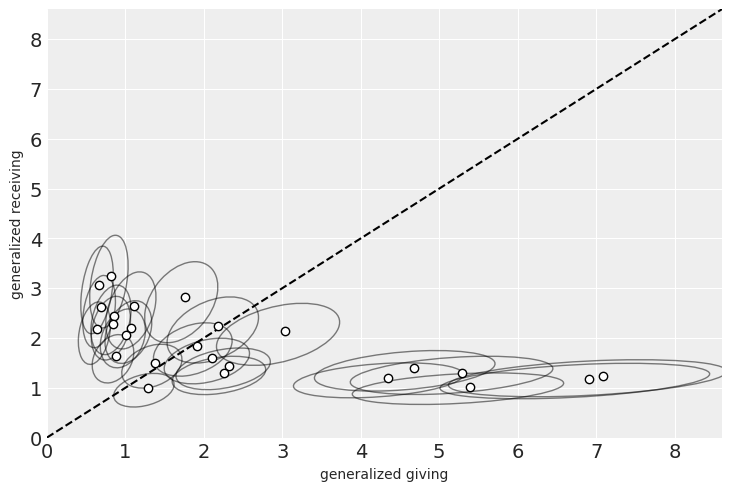

In [67]:
ax = plt.subplot(
    xlim=(0, 8.6),
    ylim=(0, 8.6),
    xlabel="generalized giving",
    ylabel="generalized receiving",
)
x = jnp.linspace(0, 9, 101)
plt.plot(x, 0 + 1 * x, "k--", lw=1.5)

# ellipses
for i in range(25):
    Sigma = jnp.cov(jnp.stack([jnp.exp(g)[:, i], jnp.exp(r)[:, i]]))
    Mu = jnp.stack([jnp.exp(jnp.mean(g[:, i])), jnp.exp(jnp.mean(r[:, i]))])
    for l in [0.5]:
        pearson = Sigma[0, 1] / jnp.sqrt(Sigma[0, 0] * Sigma[1, 1])
        ellipse = Ellipse(
            (0, 0),
            jnp.sqrt(1 + pearson),
            jnp.sqrt(1 - pearson),
            edgecolor="k",
            alpha=0.5,
            facecolor="none",
        )
        std_dev = dist.Normal().icdf((1 + jnp.sqrt(l)) / 2)
        scale_x = 2 * std_dev * jnp.sqrt(Sigma[0, 0])
        scale_y = 2 * std_dev * jnp.sqrt(Sigma[1, 1])
        scale = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y)
        ellipse.set_transform(scale.translate(Mu[0], Mu[1]) + ax.transData)
        ax.add_patch(ellipse)
# household means
plt.plot(Eg_mu, Er_mu, "ko", mfc="white", lw=1.5)
plt.show()

### Code 14.35

In [68]:
predictive = Predictive(
    m14_7.sampler.model, m14_7.get_samples(), return_sites=["Rho_d", "sigma_d"]
)
link = predictive(random.PRNGKey(1), **kl_data, link=True)
print_summary({k: v.reshape((4, -1) + v.shape[1:]) for k, v in link.items()}, 0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
Rho_d[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
Rho_d[0,1]      0.88      0.03      0.88      0.83      0.94   1574.72      1.00
Rho_d[1,0]      0.88      0.03      0.88      0.83      0.94   1574.72      1.00
Rho_d[1,1]      1.00      0.00      1.00      1.00      1.00     63.97      1.00
   sigma_d      1.10      0.06      1.10      1.01      1.19   1835.23      1.00



### Code 14.36

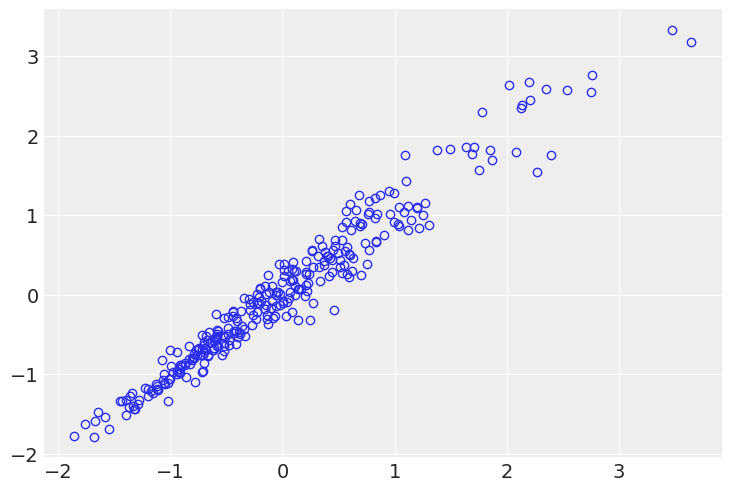

In [69]:
predictive = Predictive(m14_7.sampler.model, m14_7.get_samples(), return_sites=["d"])
post_d = predictive(random.PRNGKey(1), **kl_data, link=True)["d"]
dy1 = jnp.mean(post_d[..., 0], 0)
dy2 = jnp.mean(post_d[..., 1], 0)
plt.plot(dy1, dy2, "o", mfc="none")
plt.show()

### Code 14.37

In [70]:
# load the distance matrix
islandsDistMatrix = pd.read_csv("../data/islandsDistMatrix.csv", index_col=0)

# display (measured in thousands of km)
Dmat = islandsDistMatrix
Dmat.columns = ["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"]
Dmat.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


### Code 14.38

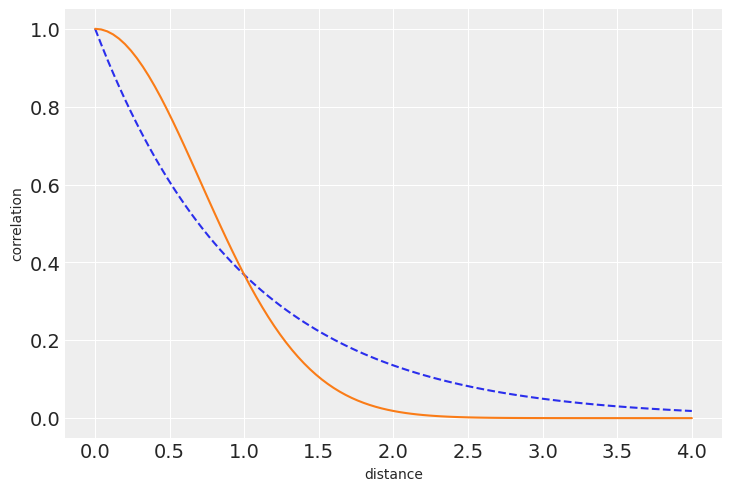

In [71]:
# linear
x = jnp.linspace(0, 4, 101)
plt.plot(x, jnp.exp(-1 * x), "--")
plt.gca().set(xlabel="distance", ylabel="correlation")

# squared
x = jnp.linspace(0, 4, 101)
plt.plot(x, jnp.exp(-1 * x ** 2))
plt.show()

### Code 14.39

In [73]:
Kline2 = pd.read_csv("../data/Kline2.csv", sep=";")
d = Kline2
d["society"] = range(1, 11)  # index observations

dat_list = dict(
    T=d.total_tools.values,
    P=d.population.values,
    society=d.society.values - 1,
    Dmat=islandsDistMatrix.values,
)


def cov_GPL2(x, sq_eta, sq_rho, sq_sigma):
    N = x.shape[0]
    K = sq_eta * jnp.exp(-sq_rho * jnp.square(x))
#     K = ops.index_add(K, jnp.diag_indices(N), sq_sigma)
    K = K.at[jnp.diag_indices(N)].set(sq_sigma)
    return K


def model(Dmat, P, society, T):
    a = numpyro.sample("a", dist.Exponential(1))
    b = numpyro.sample("b", dist.Exponential(1))
    g = numpyro.sample("g", dist.Exponential(1))
    etasq = numpyro.sample("etasq", dist.Exponential(2))
    rhosq = numpyro.sample("rhosq", dist.Exponential(0.5))
    SIGMA = cov_GPL2(Dmat, etasq, rhosq, 0.01)
    k = numpyro.sample("k", dist.MultivariateNormal(0, SIGMA))
    lambda_ = a * P ** b / g * jnp.exp(k[society])
    numpyro.sample("T", dist.Poisson(lambda_), obs=T)


m14_8 = MCMC(NUTS(model), num_warmup=1000, num_samples=1000, num_chains=4)
m14_8.run(random.PRNGKey(0), **dat_list)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### Code 14.40

In [74]:
m14_8.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      1.86      1.61      1.06      0.68      4.62       nan 7083591.75
         b      1.94      1.92      1.39      0.14      4.85       nan 4168960.89
     etasq      3.04      2.68      2.74      0.30      6.40      2.00 8439310.72
         g      2.88      2.74      2.40      0.15      6.58       nan 12286880.66
      k[0]     -0.03      1.08     -0.46     -0.96      1.76      2.00 227122.19
      k[1]     -0.65      0.96     -0.75     -1.82      0.71      2.00 237829.31
      k[2]      1.04      0.69      1.15      0.01      1.87       nan 144369.78
      k[3]     -0.73      1.04     -0.91     -1.83      0.72      2.00 336342.66
      k[4]      0.73      0.57      0.68      0.17      1.39      2.00 151978.31
      k[5]      0.17      0.54      0.06     -0.46      1.01      2.00 187536.06
      k[6]     -0.65      0.63     -0.83     -1.28      0.34      2.00 413057.00
      k[7]     -0.38  

### Code 14.41

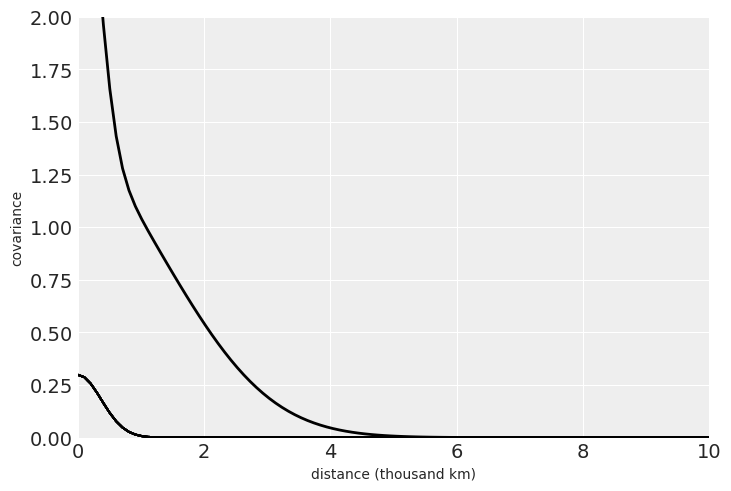

In [80]:
post = m14_8.get_samples()

# plot the posterior median covariance function
plt.subplot(
    xlabel="distance (thousand km)", ylabel="covariance", xlim=(0, 10), ylim=(0, 2)
)

# compute posterior mean covariance
x_seq = jnp.linspace(0, 10, 100)
pmcov = vmap(lambda x: post["etasq"] * jnp.exp(-post["rhosq"] * x ** 2))(x_seq)
pmcov_mu = jnp.mean(pmcov, 1)
plt.plot(x_seq, pmcov_mu, lw=2, c="k")

# plot 50 functions sampled from posterior
x = x_seq
for i in range(50):
    plt.plot(
        x_seq, post["etasq"][i] * jnp.exp(-post["rhosq"][i] * x ** 2), "k", alpha=0.15
    )

### Code 14.42

In [79]:
# compute posterior median covariance among societies
K = jnp.zeros((10, 10))
for i in range(10):
    for j in range(10):
        K = K.at[i, j].set(
            jnp.median(post["etasq"])
            * jnp.exp(-jnp.median(post["rhosq"]) * islandsDistMatrix.values[i, j] ** 2)
        )
#         K = ops.index_update(
#             K,
#             ops.index[i, j],,
#         )
# K = ops.index_update(K, jnp.diag_indices(10), jnp.median(post["etasq"]) + 0.01)
K = K.at[jnp.diag_indices(10)].set(jnp.median(post["etasq"]) + 0.01)

### Code 14.43

In [92]:
# convert to correlation matrix
Rho = jnp.round(K / jnp.sqrt(jnp.outer(jnp.diagonal(K), jnp.diagonal(K))), 2)
# add row/col names for convenience
Rho = pd.DataFrame(Rho)
Rho.columns = ["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"]
Rho.index = Rho.columns
Rho

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Ml,1.00,0.56,0.36,0.0,0.02,0.00,0.00,0.00,0.00,0.0
Ti,0.56,1.00,0.78,0.0,0.02,0.00,0.00,0.00,0.00,0.0
SC,0.36,0.78,1.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0
Ya,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00,0.0
Fi,0.02,0.02,0.00,0.0,1.00,0.00,0.00,0.00,0.23,0.0
Tr,0.00,0.00,0.00,0.0,0.00,1.00,0.00,0.16,0.00,0.0
Ch,0.00,0.00,0.00,0.0,0.00,0.00,1.00,0.02,0.00,0.0
Mn,0.00,0.00,0.00,0.0,0.00,0.16,0.02,1.00,0.00,0.0
To,0.00,0.00,0.00,0.0,0.23,0.00,0.00,0.00,1.00,0.0
Ha,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,1.0


### Code 14.44

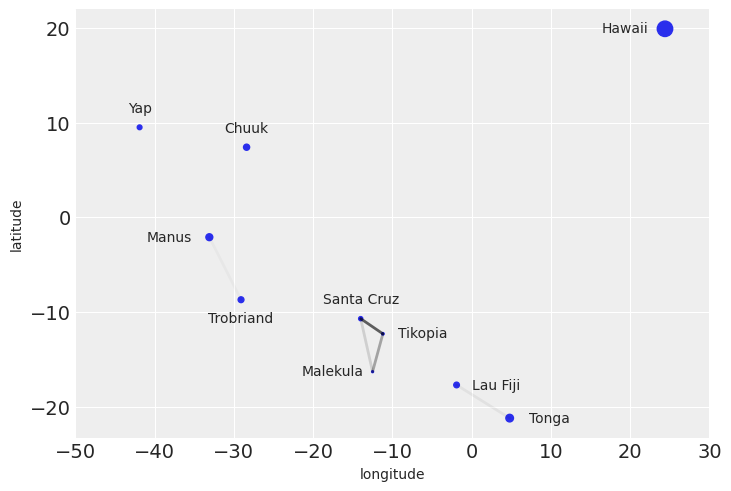

In [95]:
# scale point size to logpop
psize = d.logpop.values / d.logpop.max()
psize = jnp.exp(psize * 1.5) - 2

# plot raw data and labels
plt.scatter(d.lon2, d.lat, s=(psize ** 2) * 20)
plt.gca().set(xlabel="longitude", ylabel="latitude", xlim=(-50, 30))
labels = d.culture.values
pos = [2, 4, 3, 3, 4, 1, 3, 2, 4, 2]
for i in range(len(labels)):
    dx = [0, -5, 0, 5][pos[i] - 1]
    dy = [-2, 0, 2, 0][pos[i] - 1]
    plt.annotate(
        labels[i],
        (d.lon2[i], d.lat[i]),
        (d.lon2[i] + dx, d.lat[i] + dy),
        ha="center",
        va="center",
    )

# overlay lines shaded by Rho
for i in range(10):
    for j in range(10):
        if i < j:
            plt.plot(
                [d.lon2[i], d.lon2[j]],
                [d.lat[i], d.lat[j]],
                lw=2,
                c="k",
                alpha=Rho.values[i, j] ** 2,
            )
plt.show()

### Code 14.45

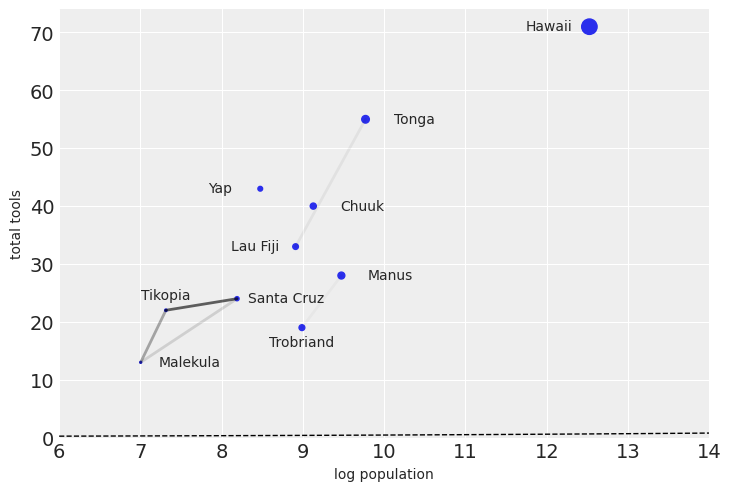

In [97]:
# compute posterior median relationship, ignoring distance
logpop_seq = jnp.linspace(6, 14, num=30)
lambda_ = vmap(lambda lp: post["a"] * jnp.exp(lp) ** post["b"] / post["g"])(logpop_seq)
lambda_median = jnp.median(lambda_, 1)
lambda_PI80 = jnp.percentile(lambda_, q=jnp.array((10, 90)), axis=1)

# plot raw data and labels
plt.scatter(d.logpop, d.total_tools, s=(psize ** 2) * 20)
plt.gca().set(xlabel="log population", ylabel="total tools", xlim=(6, 14), ylim=(0, 74))
pos = [4, 3, 4, 2, 2, 1, 4, 4, 4, 2]
for i in range(len(labels)):
    dx = [0, -0.5, 0, 0.6][pos[i] - 1]
    dy = [-2.5, 0, 2.5, 0][pos[i] - 1]
    plt.annotate(
        labels[i],
        (d.logpop[i], d.total_tools[i]),
        (d.logpop[i] + dx, d.total_tools[i] + dy),
        va="center",
        ha="center",
        zorder=3,
    )

# display posterior predictions
plt.plot(logpop_seq, lambda_median, "k--", lw=1)
plt.plot(logpop_seq, lambda_PI80[0], "k--", lw=1)
plt.plot(logpop_seq, lambda_PI80[1], "k--", lw=1)

# overlay correlations
for i in range(10):
    for j in range(10):
        if i < j:
            plt.plot(
                [d.logpop[i], d.logpop[j]],
                [d.total_tools[i], d.total_tools[j]],
                lw=2,
                c="k",
                alpha=Rho.values[i, j] ** 2,
            )

### Code 14.46

In [47]:
def model(Dmat, P, society, T):
    a = numpyro.sample("a", dist.Exponential(1))
    b = numpyro.sample("b", dist.Exponential(1))
    g = numpyro.sample("g", dist.Exponential(1))
    etasq = numpyro.sample("etasq", dist.Exponential(2))
    rhosq = numpyro.sample("rhosq", dist.Exponential(0.5))

    # non-centered Gaussian Process prior
    SIGMA = cov_GPL2(Dmat, etasq, rhosq, 0.01)
    L_SIGMA = jnp.linalg.cholesky(SIGMA)
    z = numpyro.sample("z", dist.Normal(0, 1).expand([10]))
    k = (L_SIGMA @ z[..., None])[..., 0]

    lambda_ = a * P ** b / g * jnp.exp(k[society])
    numpyro.sample("T", dist.Poisson(lambda_), obs=T)


m14_8nc = MCMC(NUTS(model), num_warmup=1000, num_samples=1000, num_chains=4)
m14_8nc.run(random.PRNGKey(0), **dat_list)

### Code 14.47

```python
# conda install -c etetoolkit ete3
from ete3 import Tree, TreeStyle

Primates301_nex = Tree("../data/Primates301.newick")

circular_style = TreeStyle()
circular_style.mode = "c"
Primates301_nex.render("../data/Primates301.png", tree_style=circular_style)
```

In [ ]:
Primates301 = pd.read_csv("../data/Primates301.csv", sep=";")

# plot it
Image("../data/Primates301.png")

### Code 14.48

In [99]:
d = Primates301
d["name"] = d.name
dpyro = d.loc[d[["group_size", "body", "brain"]].dropna().index]
spp_obs = dpyro.name

### Code 14.49

In [50]:
dat_list = dict(
    N_spp=dpyro.shape[0],
    M=dpyro.body.apply(math.log).pipe(lambda x: (x - x.mean()) / x.std()).values,
    B=dpyro.brain.apply(math.log).pipe(lambda x: (x - x.mean()) / x.std()).values,
    G=dpyro.group_size.apply(math.log).pipe(lambda x: (x - x.mean()) / x.std()).values,
    Imat=jnp.identity(dpyro.shape[0]),
)


def model(N_spp, M, B, Imat, G):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bG = numpyro.sample("bG", dist.Normal(0, 0.5))
    sigma_sq = numpyro.sample("sigma_sq", dist.Exponential(1))
    mu = a + bM * M + bG * G
    SIGMA_sqrt = jnp.sqrt(sigma_sq)
    numpyro.sample("B", dist.Normal(mu, SIGMA_sqrt), obs=B)


m14_9 = MCMC(NUTS(model), 500, 500, num_chains=4)
m14_9.run(random.PRNGKey(0), **dat_list)
m14_9.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.00      0.02      0.00     -0.03      0.03   1578.41      1.00
        bG      0.12      0.02      0.12      0.09      0.16   1471.43      1.00
        bM      0.89      0.02      0.89      0.86      0.93   1525.57      1.00
  sigma_sq      0.05      0.01      0.05      0.04      0.06   1669.03      1.00

Number of divergences: 0


### Code 14.50

```python
tree_trimmed = Primates301_nex.copy()
tree_trimmed.prune(spp_obs)
```

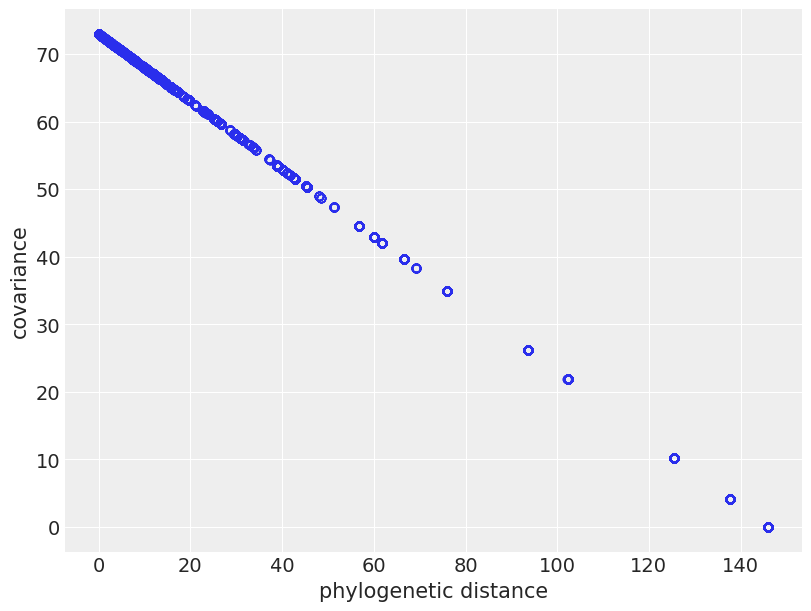

In [51]:
V = pd.read_csv("../data/Primates301_vcov_matrix.csv", index_col=0)
Dmat = pd.read_csv("../data/Primates301_distance_matrix.csv", index_col=0)
plt.figure(figsize=(8, 6))
plt.plot(Dmat.values.reshape(-1), V.values.reshape(-1), "o", mfc="none")
plt.gca().set(xlabel="phylogenetic distance", ylabel="covariance")
set_matplotlib_formats("png")

### Code 14.51

In [52]:
# put species in right order
dat_list["V"] = V.loc[spp_obs, spp_obs].values
# convert to correlation matrix
dat_list["R"] = dat_list["V"] / jnp.max(V.values)

# Brownian motion model
def model(M, B, R, G):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bG = numpyro.sample("bG", dist.Normal(0, 0.5))
    sigma_sq = numpyro.sample("sigma_sq", dist.Exponential(1))
    mu = a + bM * M + bG * G
    SIGMA = R * sigma_sq
    numpyro.sample("B", dist.MultivariateNormal(mu, SIGMA), obs=B)


m14_10 = MCMC(NUTS(model), 500, 500, num_chains=4, chain_method="sequential")
m14_10.run(random.PRNGKey(0), **{k: v for k, v in dat_list.items() if k in "MBRG"})
m14_10.print_summary(0.89)

sample: 100%|██████████| 1000/1000 [00:09<00:00, 101.98it/s, 3 steps of size 7.97e-01. acc. prob=0.90]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.20      0.17     -0.19     -0.46      0.06   1809.85      1.00
        bG     -0.01      0.02     -0.01     -0.04      0.02   2433.39      1.00
        bM      0.70      0.04      0.70      0.64      0.76   2007.01      1.00
  sigma_sq      0.16      0.02      0.16      0.13      0.19   1971.57      1.00

Number of divergences: 0


### Code 14.52

In [53]:
# add scaled and reordered distance matrix
dat_list["Dmat"] = Dmat.loc[spp_obs, spp_obs].values / jnp.max(Dmat.values)


def model(M, B, Dmat, G):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bG = numpyro.sample("bG", dist.Normal(0, 0.5))
    etasq = numpyro.sample("etasq", dist.Exponential(1))
    rhosq = numpyro.sample("rhosq", dist.Exponential(1))
    SIGMA = cov_GPL2(Dmat, etasq, rhosq, 0.01)
    mu = a + bM * M + bG * G
    numpyro.sample("B", dist.MultivariateNormal(mu, SIGMA), obs=B)


m14_11 = MCMC(NUTS(model), 500, 500, num_chains=4, chain_method="sequential")
m14_11.run(
    random.PRNGKey(0), dat_list["M"], dat_list["B"], dat_list["Dmat"], dat_list["G"]
)
m14_11.print_summary(0.89)

sample: 100%|██████████| 1000/1000 [00:32<00:00, 30.97it/s, 15 steps of size 2.20e-01. acc. prob=0.93]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.06      0.50     -0.07     -0.85      0.68   1211.11      1.00
        bG      0.04      0.02      0.04      0.00      0.07   1548.87      1.00
        bM      0.76      0.03      0.76      0.71      0.82   1495.21      1.00
     etasq      0.57      0.56      0.40      0.06      1.17    815.67      1.00
     rhosq      0.75      0.63      0.56      0.07      1.55    757.34      1.00

Number of divergences: 0


### Code 14.53

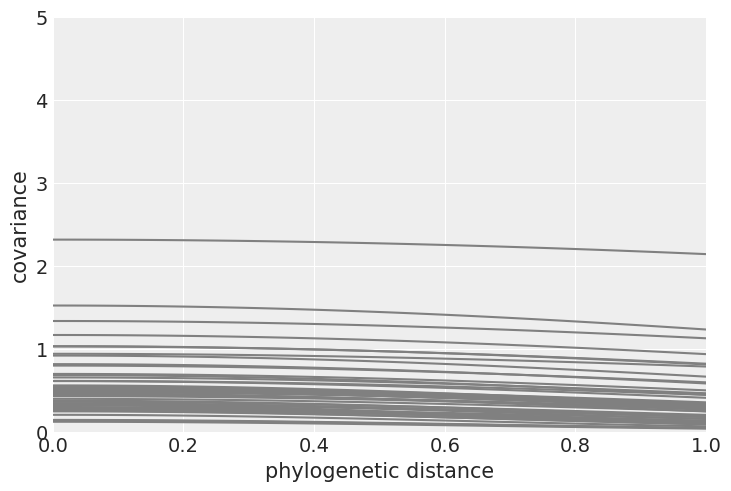

In [54]:
post = m14_11.get_samples()
plt.subplot(
    xlim=(0, jnp.max(dat_list["Dmat"]).item()),
    ylim=(0, 5),
    xlabel="phylogenetic distance",
    ylabel="covariance",
)
x = jnp.linspace(0, jnp.max(dat_list["Dmat"]), 101)
for i in range(50):
    plt.plot(x, post["etasq"][i] * jnp.exp(-post["rhosq"][i] * x ** 2), "gray")
if "SVG" in os.environ:
    set_matplotlib_formats("svg")

### Code 14.54

In [55]:
sa = 1
sb = 0.5
rho = -0.7
S = jnp.array([[sa ** 2, a * sb * rho], [a * sb * rho, sb ** 2]])